In [1]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [2]:
# Load dataset (same logic as before)
file_path = '/Users/m.mughees/Desktop/2025-IEEE_SciVis-Contest-Mughees/data/Dataset_VisContest_Rapid_Alloy_development_v3.txt'
try:
    df = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')
except Exception:
    df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')

In [3]:

# Output columns (targets)
target_cols = ['YS(MPa)', 'CSC', 'Therm.conductivity(W/(mK))']

# Input features: composition only for now
composition_cols = ['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']

# Optional: Add microstructure features if desired later
# micro_cols = [col for col in df.columns if col.startswith(('Vf_', 'T_', 'delta_T'))]

# Drop rows with missing values in inputs or targets
df_model = df[composition_cols + target_cols].dropna()

# Final shapes
print("✅ Data prepared!")
print("Input shape:", df_model[composition_cols].shape)
print("Target shape:", df_model[target_cols].shape)
df_model.head()


✅ Data prepared!
Input shape: (324632, 10)
Target shape: (324632, 3)


,Al,Cu,Mg,Mn,Fe,Si,Zn,Ni,Cr,Ti,YS(MPa),CSC,Therm.conductivity(W/(mK))
0,83.67500,0.900000,1.050,0.025000,0.55000,12.25000,0.125000,1.3000,0.05000,0.025000,384.67201,0.478438,159.046
1,84.11885,0.874425,1.017,0.065425,0.55495,11.86555,0.122525,1.2571,0.04835,0.024175,383.73928,0.479781,160.429
2,84.56270,0.848850,0.984,0.105850,0.55990,11.48110,0.120050,1.2142,0.04670,0.023350,381.73599,0.480653,161.346
3,85.00655,0.823275,0.951,0.146275,0.56485,11.09665,0.117575,1.1713,0.04505,0.022525,379.77859,0.480645,162.105
4,85.45040,0.797700,0.918,0.186700,0.56980,10.71220,0.115100,1.1284,0.04340,0.021700,377.97213,0.479638,163.127


In [4]:
X = df_model[['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']]
y_ys = df_model['YS(MPa)']
y_csc = df_model['CSC']
y_cond = df_model['Therm.conductivity(W/(mK))']

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(X, y_ys, test_size=0.2, random_state=42)

# --- Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [5]:
#Testing for data leakage

print(y_ys.describe())
print(y_csc.describe())
print(y_cond.describe())


print(X.columns)



count    324632.000000
mean        277.797555
std          41.714142
min         194.422830
25%         245.984650
50%         264.841275
75%         306.806645
max         423.404970
Name: YS(MPa), dtype: float64
count    324632.000000
mean          0.456215
std           0.063712
min           0.313578
25%           0.424489
50%           0.448343
75%           0.468313
max           1.171836
Name: CSC, dtype: float64
count    324632.000000
mean        176.167594
std           8.009061
min         148.924000
25%         170.532000
50%         176.232000
75%         181.953000
max         198.787000
Name: Therm.conductivity(W/(mK)), dtype: float64
Index(['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti'], dtype='object')


In [6]:
# --- Input features ---
X = df_model[['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']]

# --- Target variables ---
targets = {
    "YS (MPa)": df_model["YS(MPa)"],
    "CSC": df_model["CSC"],
    "Thermal Conductivity (W/mK)": df_model["Therm.conductivity(W/(mK))"]
}

# --- Store models and metrics ---
models = {}   # format: models["YS (MPa)"]["rf"] = model
metrics = {}  # format: metrics["YS (MPa)"]["rf"] = {rmse, r2}
importances = {} 

for name, y in targets.items():
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    # Fit models
    lr.fit(X_train_scaled, y_train)
    rf.fit(X_train_scaled, y_train)

    # Predict
    y_pred_lr = lr.predict(X_test_scaled)
    y_pred_rf = rf.predict(X_test_scaled)

    mse_lr = mean_squared_error(y_test, y_pred_lr)
    mse_rf = mean_squared_error(y_test, y_pred_rf)


    # Evaluate
    metrics[name] = {
        "Linear Regression": {
            "RMSE": np.sqrt(mse_lr),
            "R²": r2_score(y_test, y_pred_lr)
        },
        "Random Forest": {
            "RMSE": np.sqrt(mse_rf),
            "R²": r2_score(y_test, y_pred_rf)
        }
    }

    # Store trained models
    models[name] = {"lr": lr, "rf": rf}

    # Store feature importances for Random Forest
    importances[name] = sorted(
        zip(X.columns, rf.feature_importances_), 
        key=lambda x: x[1], reverse=True
    )

# --- Display metrics ---
for target, model_results in metrics.items():
    print(f"\n📈 Results for: {target}")
    for model_name, result in model_results.items():
        print(f"  🔹 {model_name}")
        print(f"     RMSE: {result['RMSE']:.4f}")
        print(f"     R²: {result['R²']:.4f}")


# --- Display feature importances ---
for target, feature_list in importances.items():
    print(f"\n🔍 Top Features for: {target}")
    for feat, score in feature_list:
        print(f"   {feat}: {score:.4f}")


📈 Results for: YS (MPa)
  🔹 Linear Regression
     RMSE: 11.0944
     R²: 0.9292
  🔹 Random Forest
     RMSE: 0.3548
     R²: 0.9999

📈 Results for: CSC
  🔹 Linear Regression
     RMSE: 0.0520
     R²: 0.3290
  🔹 Random Forest
     RMSE: 0.0012
     R²: 0.9997

📈 Results for: Thermal Conductivity (W/mK)
  🔹 Linear Regression
     RMSE: 1.0614
     R²: 0.9823
  🔹 Random Forest
     RMSE: 0.0926
     R²: 0.9999

🔍 Top Features for: YS (MPa)
   Si: 0.9371
   Al: 0.0406
   Mn: 0.0071
   Cu: 0.0051
   Zn: 0.0039
   Fe: 0.0031
   Ti: 0.0019
   Mg: 0.0010
   Ni: 0.0001
   Cr: 0.0001

🔍 Top Features for: CSC
   Ni: 0.5064
   Cu: 0.1839
   Al: 0.1426
   Si: 0.1334
   Ti: 0.0198
   Zn: 0.0073
   Mg: 0.0035
   Mn: 0.0025
   Cr: 0.0003
   Fe: 0.0002

🔍 Top Features for: Thermal Conductivity (W/mK)
   Al: 0.9302
   Cu: 0.0515
   Mn: 0.0104
   Zn: 0.0044
   Si: 0.0024
   Ni: 0.0005
   Cr: 0.0003
   Fe: 0.0002
   Ti: 0.0001
   Mg: 0.0001


In [14]:
# Define element columns
elements = ['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']

# Function to generate N new alloys with random but constrained percentages
def generate_new_alloys(n_samples=1000, total_percentage=100):
    np.random.seed(42)  # for reproducibility
    compositions = []

    for _ in range(n_samples):
        # Randomly assign weights
        weights = np.random.rand(len(elements))
        weights /= weights.sum()  # normalize to sum to 1
        composition = weights * total_percentage
        compositions.append(composition)

    df_new_alloys = pd.DataFrame(compositions, columns=elements)
    return df_new_alloys

In [15]:
# Generate 1000 new alloys
new_alloys_df = generate_new_alloys(n_samples=1000)
print("✅ Generated New Alloy Compositions:")
print(new_alloys_df.head())

✅ Generated New Alloy Compositions:
          Al         Cu         Mg         Mn         Fe         Si        Zn  \
0   7.200801  18.278161  14.073106  11.509637   2.999570   2.999106  1.116699   
1   0.520773  24.538041  21.060217   5.372031   4.600045   4.640006  7.697116   
2  15.281528   3.483974   7.296552   9.150188  11.390722  19.610414  4.987017   
3  11.929704   3.348399   1.277348  18.632243  18.961076  15.873628  5.981372   
4   3.016589  12.239978   0.850029  22.476941   6.396626  16.376487  7.704997   

          Ni         Cr         Ti  
0  16.652855  11.556865  13.613201  
1  13.275971  10.927907   7.367894  
2  12.843427  14.796040   1.160137  
3   1.917882  13.435547   8.642800  
4  12.855247  13.513800   4.569305  


In [16]:
scaler = StandardScaler()
X_existing_scaled = scaler.fit_transform(X)
new_alloys_scaled = scaler.transform(new_alloys_df)


In [17]:
predictions = {}

for target, model_set in models.items():
    rf_model = model_set['rf']
    preds = rf_model.predict(new_alloys_scaled)
    predictions[target] = preds


In [18]:
predictions_df = new_alloys_df.copy()
for prop, preds in predictions.items():
    predictions_df[prop] = preds


In [19]:
print(predictions_df.head)

<bound method NDFrame.head of             Al         Cu         Mg         Mn         Fe         Si  \
0     7.200801  18.278161  14.073106  11.509637   2.999570   2.999106   
1     0.520773  24.538041  21.060217   5.372031   4.600045   4.640006   
2    15.281528   3.483974   7.296552   9.150188  11.390722  19.610414   
3    11.929704   3.348399   1.277348  18.632243  18.961076  15.873628   
4     3.016589  12.239978   0.850029  22.476941   6.396626  16.376487   
..         ...        ...        ...        ...        ...        ...   
995  10.813695  14.196164   8.169551   5.303304   3.507302   7.374894   
996  11.854393  11.503720   9.761632  11.086243   9.913307  11.398229   
997   1.191910  17.461110  17.119645   1.081151   7.929370   3.331740   
998   6.973352  11.887917   6.147669  17.927150  17.150357  10.999389   
999   8.179149   5.904551   8.555563  14.868628   2.263047  15.575395   

            Zn         Ni         Cr         Ti    YS (MPa)       CSC  \
0     1.116699  16.6

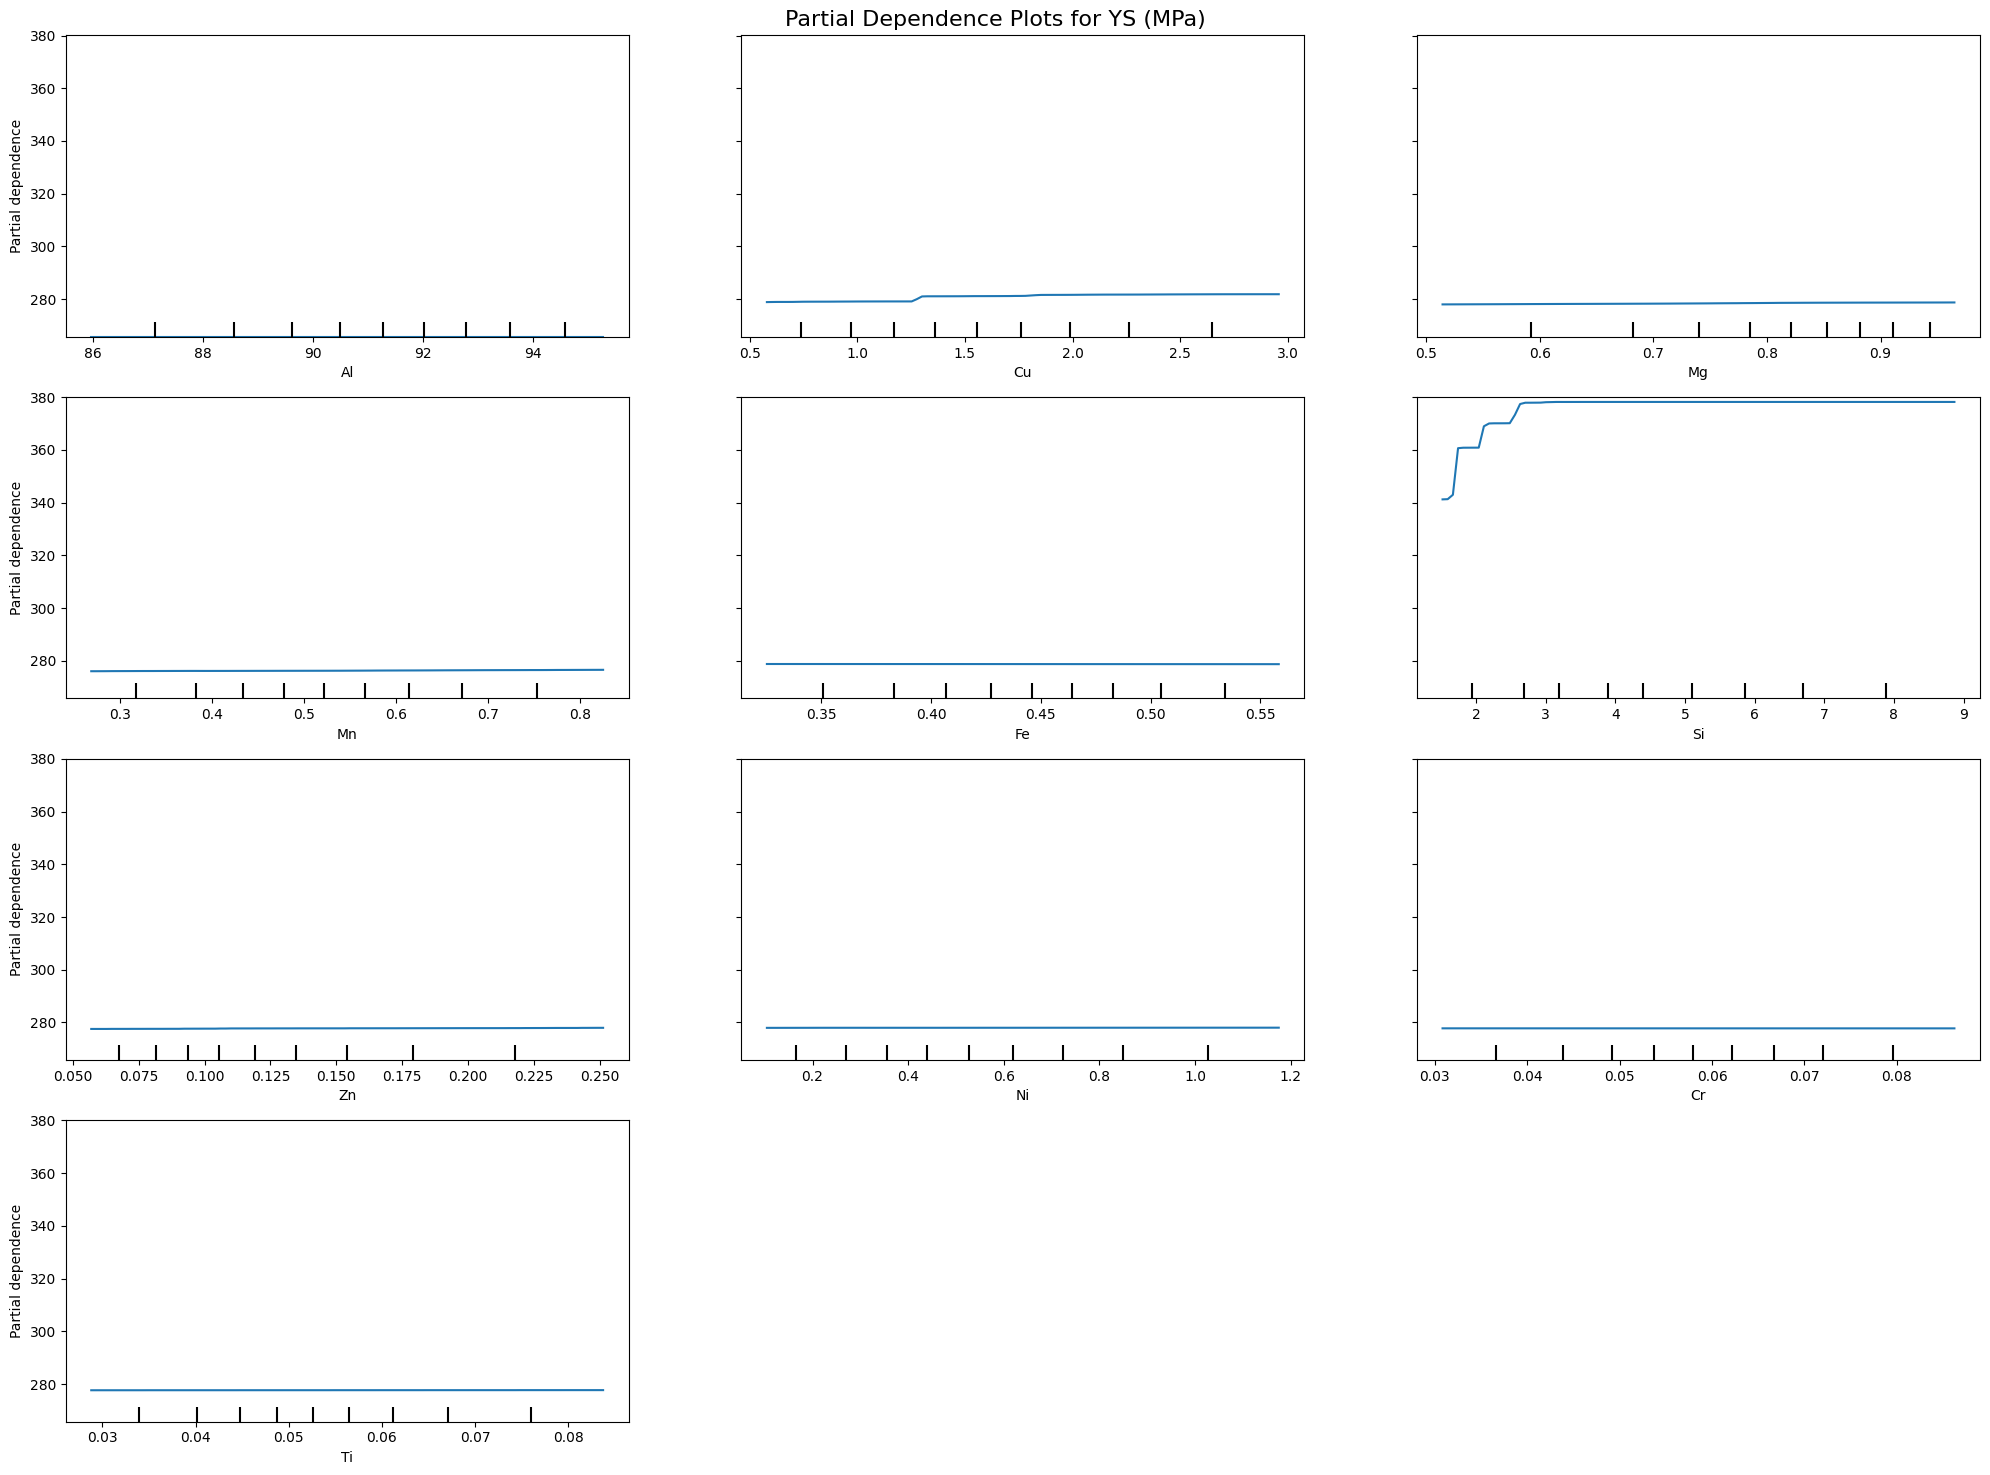

In [25]:
# Choose a property and the model you want to analyze
target_property = 'YS (MPa)'
rf_model = models[target_property]['rf']

# Features to analyze
features_to_analyze = ['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']

# Create Partial Dependence Plots
fig, ax = plt.subplots(figsize=(20, 15))
PartialDependenceDisplay.from_estimator(
    rf_model, X, features=features_to_analyze, ax=ax
)
plt.suptitle(f'Partial Dependence Plots for {target_property}', fontsize=16)
plt.tight_layout()
plt.show()

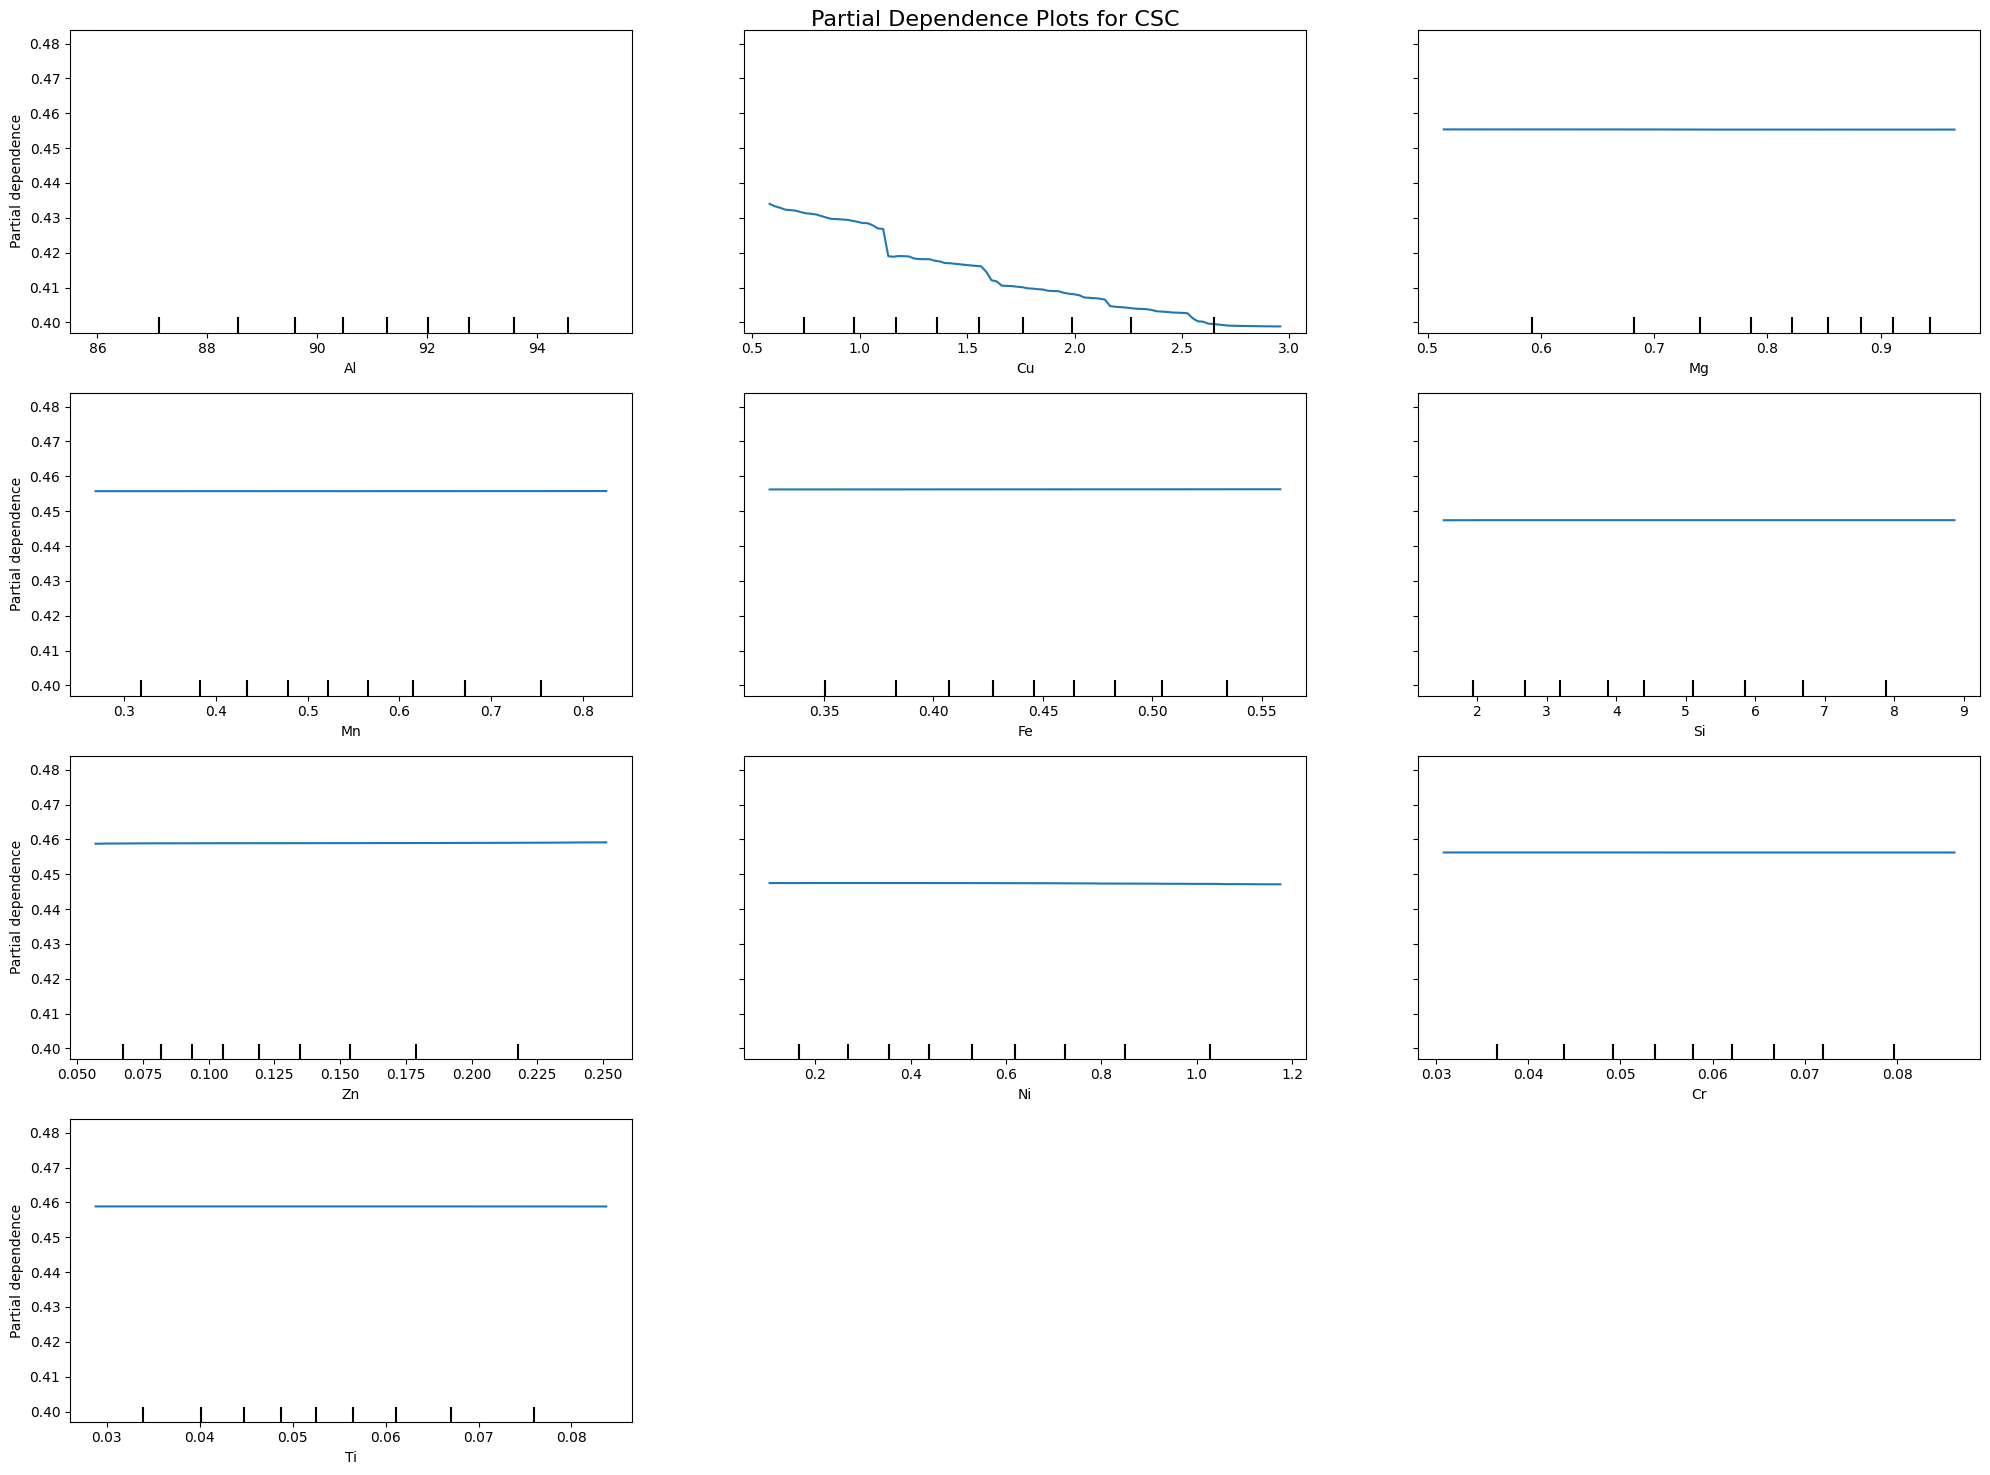

In [26]:
# Choose a property and the model you want to analyze
target_property = 'CSC'
rf_model = models[target_property]['rf']

# Features to analyze
features_to_analyze = ['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']

# Create Partial Dependence Plots
fig, ax = plt.subplots(figsize=(20, 15))
PartialDependenceDisplay.from_estimator(
    rf_model, X, features=features_to_analyze, ax=ax
)
plt.suptitle(f'Partial Dependence Plots for {target_property}', fontsize=16)
plt.tight_layout()
plt.show()

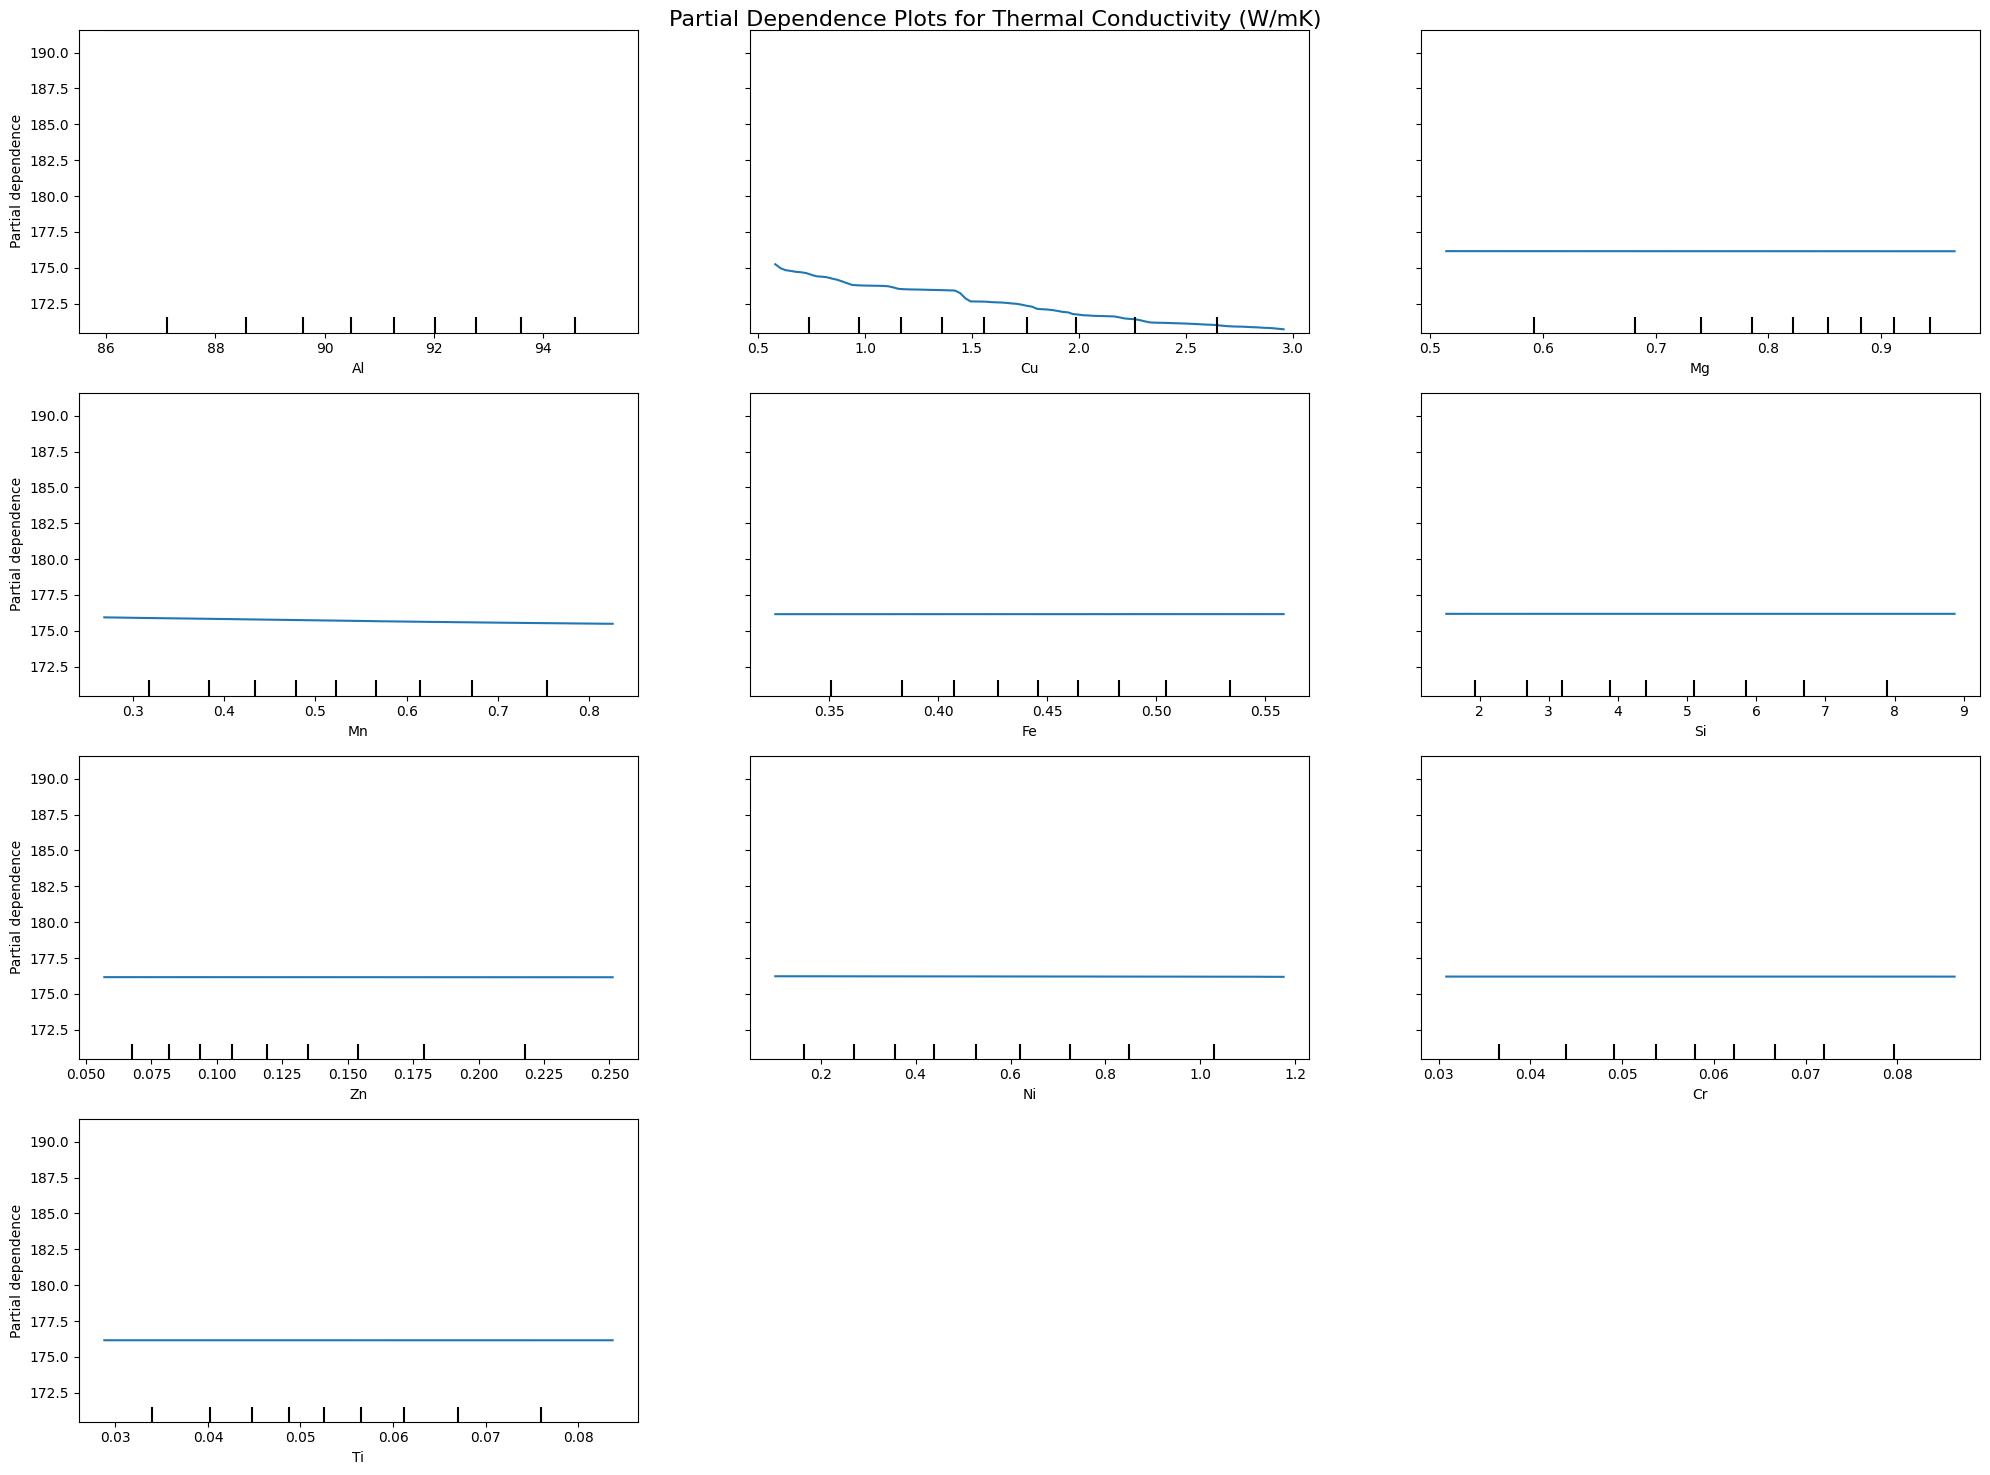

In [27]:
# Choose a property and the model you want to analyze
target_property = 'Thermal Conductivity (W/mK)'
rf_model = models[target_property]['rf']

# Features to analyze
features_to_analyze = ['Al', 'Cu', 'Mg', 'Mn', 'Fe', 'Si', 'Zn', 'Ni', 'Cr', 'Ti']

# Create Partial Dependence Plots
fig, ax = plt.subplots(figsize=(20, 15))
PartialDependenceDisplay.from_estimator(
    rf_model, X, features=features_to_analyze, ax=ax
)
plt.suptitle(f'Partial Dependence Plots for {target_property}', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def volatility_analysis(base_alloy, model, property_name, perturbation, samples=100):
    """
    base_alloy: dict of element compositions {'Al': %, 'Si': %, ...}
    model: trained RF model
    property_name: string for logging
    perturbation: max % change per element
    samples: number of perturbed samples
    """
    elements = list(base_alloy.keys())
    base_values = np.array(list(base_alloy.values()))
    
    all_preds = []

    for _ in range(samples):
        perturb_factors = 1 + np.random.uniform(-perturbation, perturbation, size=base_values.shape)
        perturbed = base_values * perturb_factors
        perturbed = perturbed / perturbed.sum() * 100  # renormalize to sum ~100%

        prediction = model.predict([perturbed])[0]
        all_preds.append(prediction)
    
    all_preds = np.array(all_preds)
    print(f"\n🔎 Volatility for {property_name}:")
    print(f"  Mean: {all_preds.mean():.3f}")
    print(f"  Std Dev: {all_preds.std():.3f}")
    print(f"  Min: {all_preds.min():.3f}")
    print(f"  Max: {all_preds.max():.3f}")

    return all_preds

In [39]:
# Example Usage
base_alloy = {'Al': 85, 'Si': 12, 'Cu': 0.5, 'Mg': 1, 'Mn': 0.2, 'Fe': 0.5, 'Zn': 0.3, 'Ni': 0.5, 'Cr': 0.2, 'Ti': 0.3}


for prop, model in models.items():
    rf_model = model['rf']
    volatility_analysis(base_alloy, rf_model, prop, 0.25)


🔎 Volatility for YS (MPa):
  Mean: 292.359
  Std Dev: 2.976
  Min: 277.110
  Max: 293.564

🔎 Volatility for CSC:
  Mean: 0.392
  Std Dev: 0.000
  Min: 0.392
  Max: 0.392

🔎 Volatility for Thermal Conductivity (W/mK):
  Mean: 181.112
  Std Dev: 0.186
  Min: 180.729
  Max: 181.736


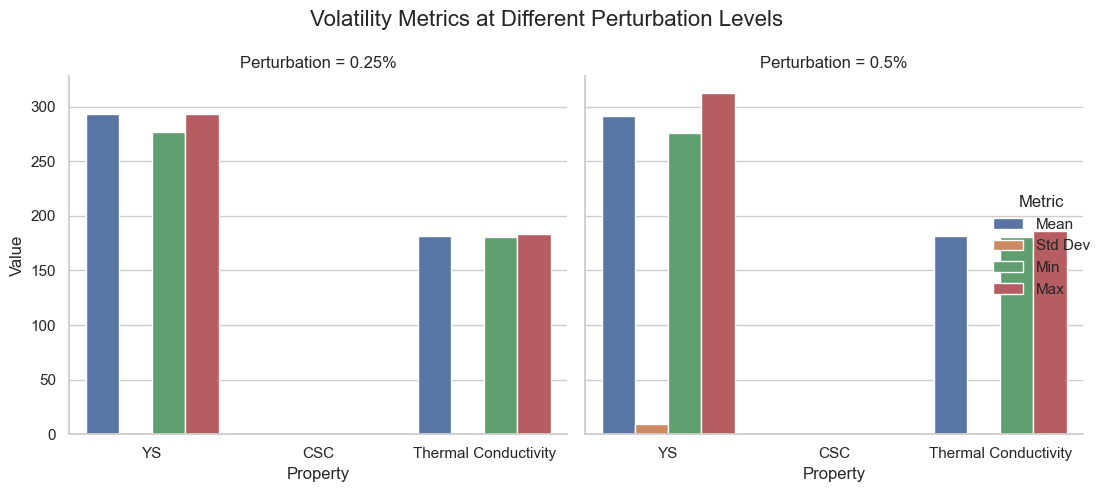

In [32]:
# Store volatility stats for both perturbations
volatility_stats = {
    '0.25%': {
        'YS': {'mean': 292.886, 'std': 1.792, 'min': 276.654, 'max': 293.564},
        'CSC': {'mean': 0.392, 'std': 0.000, 'min': 0.392, 'max': 0.392},
        'Thermal Conductivity': {'mean': 181.199, 'std': 0.387, 'min': 180.729, 'max': 183.551}
    },
    '0.5%': {
        'YS': {'mean': 291.140, 'std': 9.214, 'min': 276.088, 'max': 312.137},
        'CSC': {'mean': 0.392, 'std': 0.000, 'min': 0.392, 'max': 0.393},
        'Thermal Conductivity': {'mean': 181.830, 'std': 1.674, 'min': 180.518, 'max': 186.300}
    }
}

# Convert to DataFrame for plotting
df_stats = []
for level, props in volatility_stats.items():
    for prop, stats in props.items():
        df_stats.append({'Perturbation': level, 'Property': prop, 'Metric': 'Mean', 'Value': stats['mean']})
        df_stats.append({'Perturbation': level, 'Property': prop, 'Metric': 'Std Dev', 'Value': stats['std']})
        df_stats.append({'Perturbation': level, 'Property': prop, 'Metric': 'Min', 'Value': stats['min']})
        df_stats.append({'Perturbation': level, 'Property': prop, 'Metric': 'Max', 'Value': stats['max']})

df_stats = pd.DataFrame(df_stats)

# Plot
import seaborn as sns
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_stats, x='Property', y='Value', hue='Metric',
    col='Perturbation', kind='bar', height=5, aspect=1
)
g.fig.suptitle('Volatility Metrics at Different Perturbation Levels', fontsize=16)
plt.tight_layout()
plt.show()

In [33]:
# Expected: Low CSC, possibly reduced conductivity
base_alloy2 = {'Al': 90, 'Si': 2, 'Cu': 3, 'Mg': 0.5, 'Mn': 0.3, 'Fe': 0.3, 'Zn': 0.05, 'Ni': 1.2, 'Cr': 0.05, 'Ti': 0.05}

for prop, model in models.items():
    rf_model = model['rf']
    volatility_analysis(base_alloy2, rf_model, prop)


🔎 Volatility for YS (MPa):
  Mean: 282.923
  Std Dev: 6.511
  Min: 277.898
  Max: 293.558

🔎 Volatility for CSC:
  Mean: 0.404
  Std Dev: 0.007
  Min: 0.393
  Max: 0.417

🔎 Volatility for Thermal Conductivity (W/mK):
  Mean: 185.010
  Std Dev: 1.529
  Min: 181.156
  Max: 186.486


In [ ]:
#More steps